<a href="https://colab.research.google.com/github/Nimblesnaile/Japhys-Dead-Curve-Grapher/blob/main/Japhy's_Death_Curve_Maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


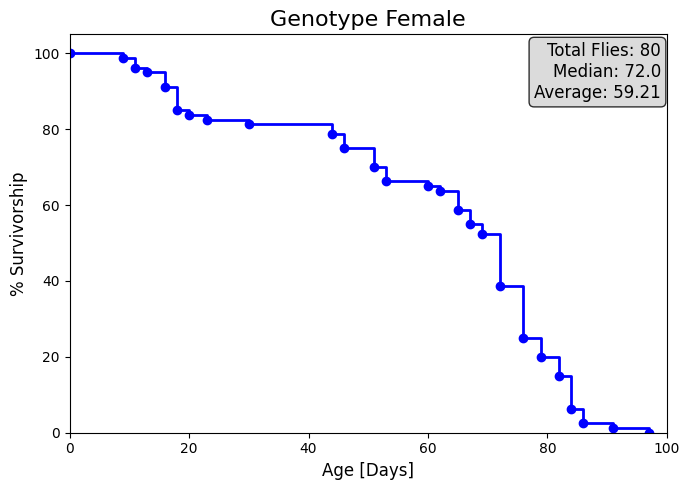

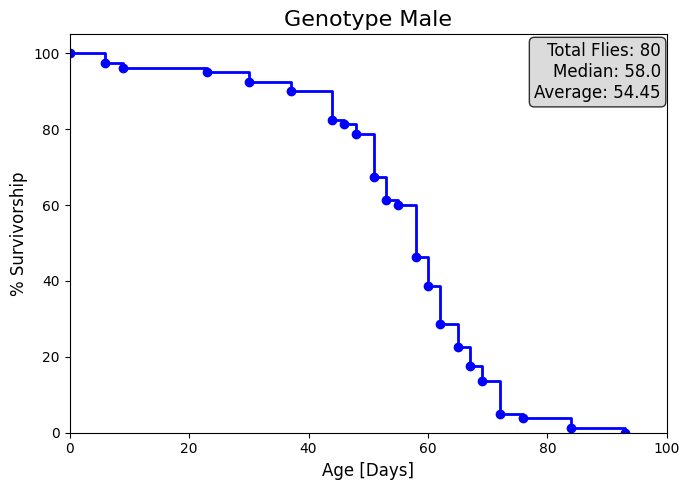

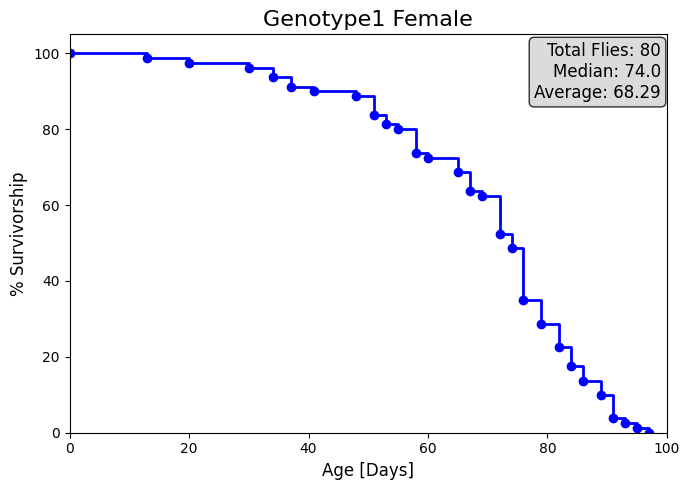

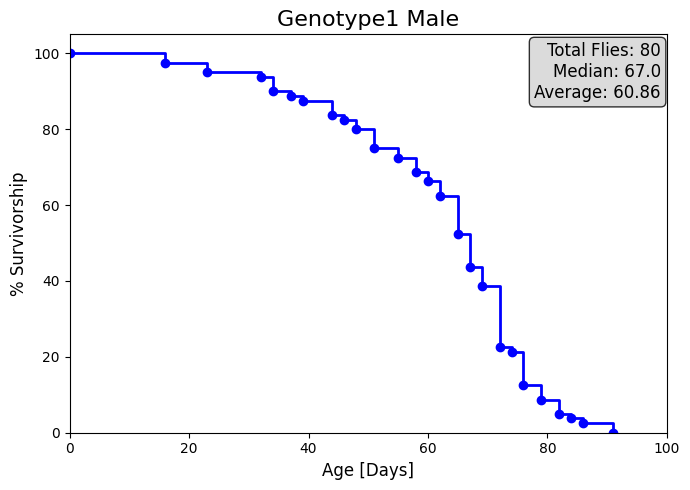

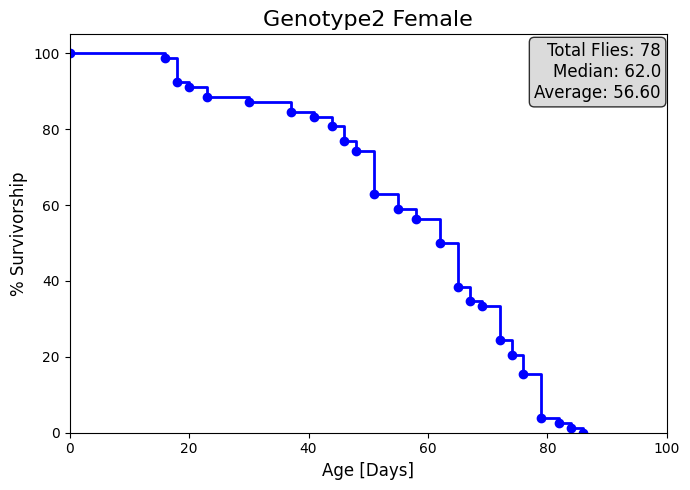

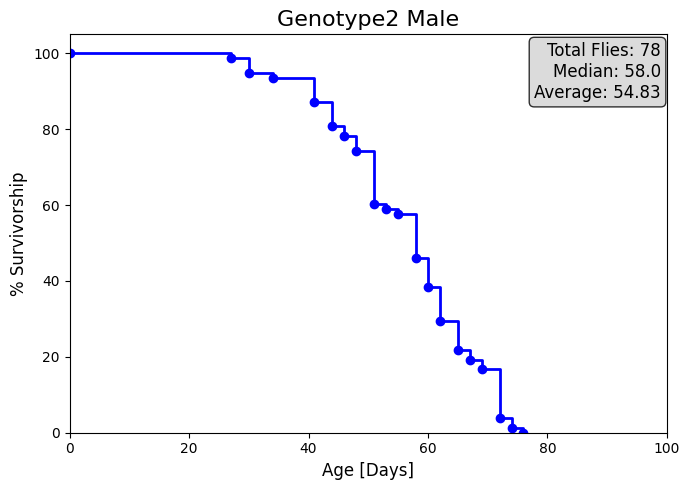

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from google.colab import drive


# Useful for my own method
# def deathCounts(data, name):
#     # Flatten the DataFrame and convert to integers
#     data = data.values.flatten()

#     # Clean up and convert
#     cleaned = []
#     for x in data:
#         s = str(x).strip().replace(',', '').replace('"', '')
#         if s in ['', 'nan']:
#             continue
#         try:
#             cleaned.append(int(s))
#         except ValueError:
#             continue
#     data = pd.Series([x for x in cleaned if x > 0])

#     counts = data.value_counts().sort_index()
#     total_flies = len(data)

#     print("Name:", name)
#     print("Total Flies:", total_flies)
#     print("Median:", data.median())
#     print("Average:", data.mean().round(2))

#     # Compute survival curve
#     days = counts.index
#     deaths = counts.values
#     alive = (total_flies - deaths.cumsum()) / total_flies * 100

#     # Add starting point
#     days = [0] + list(days)
#     alive = [100] + list(alive)

#     plt.figure(figsize=(7, 5))
#     plt.step(days, alive, where='post', color='blue', linewidth=2)
#     plt.scatter(days, alive, color='blue', s=40)
#     plt.title(f"Lifespan Curve - {name}")
#     plt.xlabel("Days Lived")
#     plt.ylabel("Percentage of Flies Alive")
#     plt.grid(alpha=0.3)
#     plt.xlim(0, 80)
#     plt.ylim(0, 110)
#     plt.show()


drive.mount("/content/drive", force_remount=True)
# CHANGE THIS TO YOUR CSV
path_to_csv = "/content/drive/My Drive/Colab Notebooks/lifespan.csv"  # insert your own path: keep everything until "Colab Notebooks"

def load_fly_data_csv(path_to_csv):
    """
    Loads a CSV with two header rows and returns:
      - days: the Day column (list)
      - data_dict: mapping 'Genotype + Sex' → alive counts list
    """
    df = pd.read_csv(path_to_csv, header=[0, 1])

    day_col = None
    for (upper, lower) in df.columns:
        if isinstance(lower, str) and lower.strip().lower() == "day":
            day_col = df[(upper, lower)].tolist()
            break

    if day_col is None:
        raise ValueError("Could not find a 'Day' column in the CSV (header row 2 must contain 'Day').")

    data_dict = {}
    for (upper, gender) in df.columns:
        if isinstance(gender, str) and gender.strip().lower() in ("female", "male"):
            full_name = f"{upper.strip()} {gender.strip()}"
            data_dict[full_name] = df[(upper, gender)].tolist()

    return day_col, data_dict


def plot_lifespan_curve(name, days, alive_counts):
    """
    Plots a survival curve:

        X-axis: Age [Days]
        Y-axis: % survivorship (computed from alive_counts)

    alive_counts = number of flies alive on each day
    days = the day values
    """
    days = np.array(days)
    alive_counts = np.array(alive_counts)

    total = alive_counts[0]

    if total == 0:
        return

    alive_pct = (alive_counts / total) * 100

    cleaned_days = [days[0]]
    cleaned_pct = [alive_pct[0]]

    for i in range(1, len(alive_pct)):
        if not np.isclose(alive_pct[i], alive_pct[i - 1]):
            cleaned_days.append(days[i])
            cleaned_pct.append(alive_pct[i])

    days = np.array(cleaned_days)
    alive_pct = np.array(cleaned_pct)

    try:
        below_50 = np.where(alive_pct <= 50)[0]
        median_val = float(days[below_50[0]]) if len(below_50) > 0 else float(days[-1])
    except Exception:
        median_val = float(days[-1])

    mean_val = float(np.trapezoid(alive_pct / 100, days))

    plt.figure(figsize=(7, 5))
    plt.step(days, alive_pct, where='post', linewidth=2, color='blue')
    plt.scatter(days, alive_pct, color='blue')

    plt.title(name, fontsize=16)
    plt.xlabel("Age [Days]", fontsize=12)
    plt.ylabel("% Survivorship", fontsize=12)
    plt.ylim(0, 105)
    plt.xlim(0, 100)

    textstr = (
        f"Total Flies: {total}\n"
        f"Median: {median_val}\n"
        f"Average: {mean_val:.2f}"
    )
    props = dict(boxstyle="round", facecolor="lightgray", alpha=0.8)

    plt.text(
        0.99, 0.98, textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=props
    )

    plt.tight_layout()
    plt.show()


def plot_all_from_csv(path_to_csv):
    days, data_dict = load_fly_data_csv(path_to_csv)

    for name in sorted(data_dict.keys()):
        plot_lifespan_curve(name, days, data_dict[name])


plot_all_from_csv(path_to_csv)
